from : https://www.kaggle.com/ritesh2000/cutmix-aug-amp-using-fastai but quieter.

In [3]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir --quiet

In [4]:
!pip install fastai --upgrade --quiet

In [5]:
!pip install pretrainedmodels --quiet
!pip install efficientnet_pytorch --quiet

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from torchvision.models import *

from torch.distributions.beta import Beta
from fastai.vision.all import *
from fastai.callback.mixup import *
import pretrainedmodels
import seaborn as sns
from fastai import *
from fastai.vision import *
from fastai.vision.models import *
from fastai.vision.learner import model_meta

import fastai
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

import sys
import pandas as pd
import torch
import numpy as np
print(fastai.__version__)

import torchvision.models as models
import torch.nn as nn

import os
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b7')




2.2.5


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth


  0%|          | 0.00/254M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b7


In [6]:
from torch.nn import Linear

model._fc = Linear(2560, 2)
nn.init.kaiming_normal_(model._fc.weight)
model = model.to(torch.device("cuda"))

In [7]:
path = "../input/cat-and-dog"

In [8]:
import albumentations

class AlbumentationsTransform(RandTransform):
    split_idx, order = None, 2
    def __init__(self, train_aug, valid_aug):
        store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [15]:
def get_train_aug(sz):
    return albumentations.Compose([
        albumentations.RandomResizedCrop(sz,sz),
        albumentations.Transpose(p=0.5),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.VerticalFlip(p=0.5),
        albumentations.ShiftScaleRotate(p=0.5),
        albumentations.HueSaturationValue(
            hue_shift_limit=0.2,
            sat_shift_limit=0.2,
            val_shift_limit=0.2,
            p=0.5
        ),
        albumentations.RandomBrightnessContrast(
            brightness_limit=(-0.1, 0.1),
            contrast_limit=(-0.1,0.1),
            p=0.5
        ),
        albumentations.CoarseDropout(p=0.5),
        albumentations.Cutout(p=0.5)
    ])

def get_valid_aug(sz):
    return albumentations.Compose([
        albumentations.CenterCrop(sz, sz, p=1.),
        albumentations.Resize(sz,sz)
    ], p=1.)

In [13]:
def get_dls(sz, bs):
    item_tfms = AlbumentationsTransform(get_train_aug(sz), get_valid_aug(sz))
    batch_tfms = [Normalize.from_stats(*imagenet_stats)]
    dls = ImageDataLoaders.from_folder(path, valid_pct=0.2, seed=999, bs=bs, item_tfms=item_tfms, batch_tfms=batch_tfms )
    return dls

In [16]:
dls = get_dls(255,16)

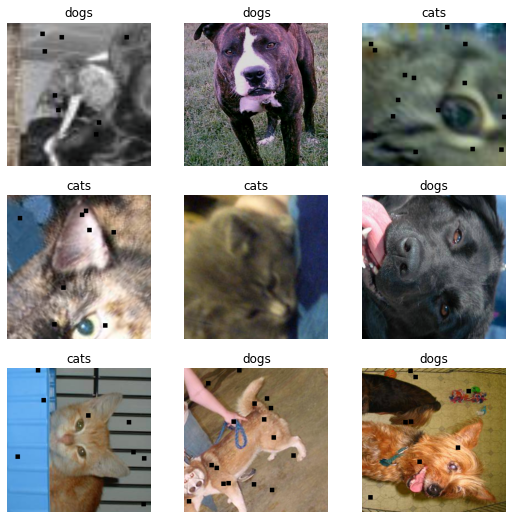

In [17]:
dls.show_batch()

In [18]:
!pip install timm --quiet

In [19]:
from fastai.vision.all import *
from fastai.callback.mixup import *
from torch.distributions.beta import Beta
import timm
set_seed(314)

In [26]:
class CutMix(MixUp):
    def __init__(self, alpha=1.): self.distrib = Beta(tensor(alpha), tensor(alpha))
    def before_batch(self):
        lam = self.distrib.sample().squeeze().to(self.x.device)
        shuffle = torch.randperm(self.y.size(0)).to(self.x.device)
        self.yb1 = tuple(L(self.yb).itemgot(shuffle))
        nx_dims = len(self.x.size())
        bs, c, h, w = self.x.shape
        rx, ry = w*self.distrib.sample(), h*self.distrib.sample()
        rw, rh = w*(1-lam).sqrt(), h*(1-lam).sqrt()
        x1 = (rx-rw/2).clamp(min=0).round().to(int)
        x2 = (rx+rw/2).clamp(max=w).round().to(int)
        y1 = (ry-rh/2).clamp(min=0).round().to(int)
        y2 = (ry+rh/2).clamp(max=h).round().to(int)
        self.learn.xb[0][:,:,y1:y2,x1:x2] = self.learn.xb[0][shuffle,:,y1:y2,x1:x2]
        self.lam = 1- float(x2-x1)*(y2-y1)/(h*w)
        
        if not self.stack_y:
            ny_dims = len(self.y.size())
            self.learn.yb = tuple(L(self.yb1,self.yb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=ny_dims-1)))

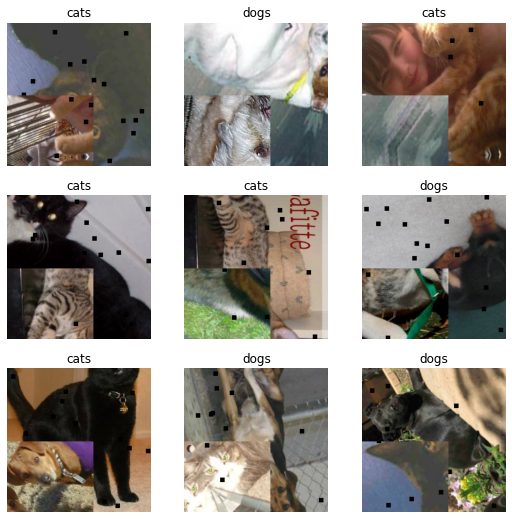

In [27]:
mixup = CutMix()
with Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=mixup) as learn:
    learn.epoch,learn.training = 0,True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_batch')

_,axs = plt.subplots(3,3, figsize=(9,9))
dls.show_batch(b=(mixup.xb[0],mixup.y), ctxs=axs.flatten())